В этом ноутбуке проводится файнтюнинг на угадывание жанра по последовательности аккордов.

In [21]:
# !pip install transformers datasets torch scikit-learn matplotlib seaborn streamlit plotly

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import random
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam, AdamW
from tqdm import tqdm
import re
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score
from typing import List, Tuple, Optional, Mapping,  Self, NamedTuple
from datasets import load_dataset
from transformers import AutoModel
import warnings
import os
warnings.filterwarnings('ignore')


Очистка датасета

In [3]:
def load_and_clean_dataset():

    dataset = load_dataset("lluccardoner/melodyGPT-song-chords-text-1")
    df = dataset['train'].to_pandas()

    def clean_chords(text):
        if not isinstance(text, str):
            return ""

        text = re.sub(r'\t', ' ', text)
        text = re.sub(r'\b(INTRO|VERSE|CHORUS|BRIDGE|OUTRO|SOLO|PRE-CHORUS)\b', '', text, flags=re.IGNORECASE)

        chords = re.findall(r'[A-G][#b]?(?:m|maj|min|aug|dim|sus2|sus4)?(?:add)?[0-9]*(?:\([0-9]+\))?(?:\/[A-G][#b]?)?', text.upper())

        return ' '.join(chords)

    df['cleaned_chords'] = df['chords_str'].apply(clean_chords)

    df = df[df['cleaned_chords'].str.len() > 0]

    return df


class ChordTransposer:

    def __init__(self):
        self.chord_map = {
            'C': 0, 'C#': 1, 'Db': 1, 'D': 2, 'D#': 3, 'Eb': 3,
            'E': 4, 'F': 5, 'F#': 6, 'Gb': 6, 'G': 7, 'G#': 8,
            'Ab': 8, 'A': 9, 'A#': 10, 'Bb': 10, 'B': 11
        }
        self.reverse_map = {v: k for k, v in self.chord_map.items()}

        self.chord_patterns = [
            # Аккорды с добавлениями в скобках: A5(9), C7(11)
            r'([A-G][#b]?)(.*)(\(.*\))',
            # Аккорды с add: Cadd9, Dmadd11
            r'([A-G][#b]?)(.*)(add.*)',
            # Аккорды с sus: Dsus4, Asus2
            r'([A-G][#b]?)(.*)(sus.*)',
            # Септаккорды и расширения: Cmaj7, G9, Am11
            r'([A-G][#b]?)(.*)(\d+)',
            # Базовые аккорды: C, Dm, E7
            r'([A-G][#b]?)(.*)'
        ]

    def transpose_chord(self, chord, steps):

        for pattern in self.chord_patterns:
            match = re.match(pattern, chord)
            if match:
                groups = match.groups()
                tone = groups[0]

                if tone in self.chord_map:

                    new_tone_num = (self.chord_map[tone] + steps) % 12
                    new_tone = self.reverse_map[new_tone_num]

                    if len(groups) == 3:
                        quality = groups[1] or ''
                        extension = groups[2] or ''
                        return new_tone + quality + extension
                    else:
                        quality = groups[1] or ''
                        return new_tone + quality

                break

        return chord

    def transpose_sequence(self, chord_sequence, steps):
        chords = chord_sequence.split()
        transposed = [self.transpose_chord(chord, steps) for chord in chords]
        return ' '.join(transposed)

def augment_dataset(df, num_transpositions=5):
    transposer = ChordTransposer()
    augmented_data = []

    for _, row in df.iterrows():
        chords = row['cleaned_chords']
        if len(chords.split()) < 3:
            continue

        augmented_data.append({
            'cleaned_chords': chords,
            'genres': row.get('genres'),
            'artist_name': row.get('artist_name', 'unknown'),
            'song_name': row.get('song_name', 'unknown')
        })

        for steps in range(1, num_transpositions + 1):
            transposed = transposer.transpose_sequence(chords, steps)
            augmented_data.append({
                'cleaned_chords': transposed,
                'genres': row.get('genres'),
                'artist_name': row.get('artist_name', 'unknown'),
                'song_name': row.get('song_name', 'unknown')
            })

    return pd.DataFrame(augmented_data)

In [4]:
dataset = load_and_clean_dataset()

In [5]:
unique_genres = set()


for lst in dataset["genres"]:
    for g in lst:
        unique_genres.add(g)


Разметка жанров

In [6]:
CATEGORY_KEYWORDS = {
    "rock": [
        "rock", "punk", "grunge", "garage", "metalcore", "post-hardcore", "post-rock",
        "thrash", "mathcore", "emo", "hard rock", "alternative", "indie rock",
        "psychedelic", "rockabilly", "southern rock", "gothic", "industrial rock",
        "progressive rock", "metal", "doom", "americana", "folk rock", "country rock"
    ],
    "pop": [
        "pop", "idol", "dance", "electropop", "teen", "bubblegum", "k-pop", "j-pop",
        "torch song", "synthpop", "mandopop", "channel pop", "viral pop", "social media pop",
        "pop rock", "pop punk", "boy group", "girl group", "catchy", "telepop", "uk dance", 'indie'
    ],
    "hip hop / rap": [
        "hip hop", "rap", "trap", "drill", "boom bap", "gangsta", "underground rap",
        "latin rap", "rap baiano", "rap francais", "rap consciente", "rap cristiano",
        "rap urbano", "rap napoletano", "rap mineiro", "rap mexicano", "rap argentino",
        "east coast rap", "west coast rap", "st louis rap", "experimental hip hop"
    ],
    "metal": [
        "metal", "black metal", "death metal", "power metal", "doom", "melodic metal",
        "metalcore", "mathcore", "symphonic metal", "progressive metal", "thrash metal",
        "industrial metal", "gothic metal", "melodic hardcore"
    ],
    "electronic / edm": [
        "edm", "electro", "house", "trance", "techno", "dubstep", "drum and bass",
        "idm", "electronica", "chiptune", "bmore", "downtempo", "future bass",
        "future house", "progressive house", "deep house", "nu disco", "synthwave",
        "vaporwave", "electro-pop", "electropowerpop", "tech house", "minimal techno",
        "classic dubstep", "german trance", "electronic", 'flow', 'disco', 'bounce', 'new beat', 'wave'
    ],
    "jazz / blues": [
        "jazz", "blues", "bebop", "swing", "fusion", "big band", "cool jazz", "smooth jazz",
        "vocal jazz", "jazz trio", "jazz rock", "jazz funk", "jazz piano", "jazz guitar",
        "jazz saxophone", "jazz trumpet", "jazz vibraphone"
    ],
    "folk / country": [
        "folk", "americana", "country", "bluegrass", "roots", "celtic", "rondoniense",
        "american", "traditional", "folk-pop", "folk rock", "country rock", "indie folk",
        "world folk", "native american", "scottish folk", "norwegian folk",
        "argentine folklore", "mexican folklore", "brazilian folk", "musica rondoniense",
        "country pop", 'carnavalera', 'nashville sound', 'irish'
    ],
    "latin / world": [
        "latin", "reggaeton", "salsa", "afrobeat", "world", "bossa", "cumbia", "mariachi",
        "vallenato", "bachata", "forro", "tango", "merengue", "samba", "musica",
        "caribbean", "african", "brazilian", "argentine", "peruvian", "dominican",
        "latin rock", "argentine telepop", "musica paranaense", 'reggae', 'venezuelan', 'murcia', 'bollywood'
    ],
    "classical": [
        "classical", "orchestra", "baroque", "opera", "symphonic", "romantic",
        "impressionism", "chamber", "early music", "tenor", "soprano", "mandolin",
        "classical era", "classical performance", "brega romantico", 'choral'
    ],
    "r&b / soul": [
        "r&b", "soul", "funk", "motown", "neo soul", "alternative r&b", "quiet storm",
        "chill r&b", "groove gospel", "urban contemporary", "soul blues", "vocal harmony",
        "scandinavian r&b", "experimental r&b"
    ],
    "punk / hardcore": [
        "punk", "hardcore", "ska", "oi!", "anarcho", "hardcore punk", "post-punk",
        "pop punk", "garage punk", "street punk", "emo", "grindcore", "early us punk",
        "psychedelic punk"
    ],
    "religious / worship": [
        "christian", "worship", "gospel", "adoracao", "sholawat", "nasheed", "louvor",
        "lds", "spirituals", "chant", "kirtan", "uvielbienie", "groove gospel", 'choral'
    ],
    "soundtrack / score / instrumental": [
        "soundtrack", "score", "instrumental", "video game music", "orchestral",
        "meditation", "theme", "film", "game", "anime score", "classify", 'movie', 'tunes'
    ],
    "children / family": ["children's music", "kindermusik", "barnemusikk", "barnmusik",
                          "kids", "nursery rhymes", "lullaby", "kids songs", "children's choir",
                          "children's folk", "musica infantil", "baby music", "kids pop", "kids edm"],
    "other / misc": [
        "comedia", "comic", "uwielbienie", "singaporean singer-songwriter", "seattle indie",
        "lagu jawa", "chinese audiophile", "gruperas inmortales", "banda carnavalera"
    ]
}

# жанр может принадлежать сразу к нескольким категориям
def map_genres_to_categories(genre_list):
    # Если это строка, превращаем в список
    if isinstance(genre_list, str):
        genre_list = [g.strip() for g in genre_list.split(",")]

    matched_categories = set()

    for genre in genre_list:
        genre_lower = genre.lower()  # работаем с жанром как строкой
        for category, keywords in CATEGORY_KEYWORDS.items():
            for kw in keywords:
                if kw in genre_lower:
                    matched_categories.add(category)

    if not matched_categories:
        matched_categories.add("other / misc")

    return list(matched_categories)

# Создание маппинга всех жанров
genre_mapping = {g: map_genres_to_categories(g) for g in unique_genres}


Выделение главного жанра

In [7]:
dataset["main_categories"] = dataset["genres"].apply(map_genres_to_categories)

In [8]:
# augmented_dataset = augment_dataset(dataset)
# augmented_dataset["main_categories"] = augmented_dataset["genres"].apply(map_genres_to_categories)

In [9]:
all_genres = sorted(set(g for sublist in dataset['main_categories'] for g in sublist))
num_classes = len(all_genres)
genre_to_idx = {g: i for i, g in enumerate(all_genres)}

def genres_to_onehot(genres):
    onehot = np.zeros(num_classes, dtype=np.float32)
    for g in genres:
        onehot[genre_to_idx[g]] = 1.0
    return onehot

dataset['genre_onehot'] = dataset['main_categories'].apply(genres_to_onehot)

Токенайзер

In [10]:
class ChordTokenizer:
    def __init__(self):
        self._padding_token = "[PAD]"
        self._unknown_token = "[UNK]"
        self._cls_token = "[CLS]"
        self._sep_token = "[SEP]"
        self._mask_token = "[MASK]"

        self._padding_id = 0
        self._cls_id = 1
        self._sep_id = 2
        self._mask_token_id = 3
        self._unknown_token_id = 4


        self.notes = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
        self.moods = ['m', 'maj', 'min', 'aug', 'dim', 'sus2', 'sus4', 'sus']
        self.extensions = [
            '5', '6', '7', '9', '11', '13',
            'add9', 'add11', 'add13'
        ]
        self.symbols = ['/', 'b', '#', '(', ')', ' ']

        self.complex_chords = [
            'A5(9)', 'Cadd9', 'Dsus4', 'Emadd9', 'G5(11)',
            'Fmaj7', 'G9', 'Am11', 'C7(9)', 'Dsus2',
            'Cmaj9', 'F#m7', 'Bbmaj7', 'E7sus4', 'Aadd9'
        ]

        self._init_vocab()

    @property
    def vocab(self) -> Mapping[int, str]:
        return self._vocab

    @property
    def reverse_vocab(self) -> Mapping[str, int]:
        return {token: idx for idx, token in self._vocab.items()}

    @property
    def cls_id(self) -> int:
        return self._cls_id

    @property
    def mask_token_id(self) -> int:
        return self._mask_token_id

    @property
    def padding_id(self) -> int:
        return self._padding_id

    @property
    def sep_id(self) -> int:
        return self._sep_id

    @property
    def unknown_token_id(self) -> int:
        return self._unknown_token_id

    def _init_vocab(self) -> None:
        """Инициализация словаря с специальными токенами"""
        self._vocab = {
            self._padding_id: self._padding_token,
            self._cls_id: self._cls_token,
            self._sep_id: self._sep_token,
            self._mask_token_id: self._mask_token,
            self._unknown_token_id: self._unknown_token,
        }

    def fit(self, corpus: List[str]) -> Self:
        """Создание словаря на основе корпуса"""
        self._init_vocab()

        all_elements = (self.notes + self.moods + self.extensions +
                       self.symbols + self.complex_chords)

        for element in all_elements:
            if element not in self._vocab.values():
                self._vocab[len(self._vocab)] = element

        for text in corpus:
            chords = text.split()
            for chord in chords:
                if chord not in self.reverse_vocab and chord not in self._vocab.values():
                    self._vocab[len(self._vocab)] = chord

        return self

    def tokenize_text(self, text: str | List[str]) -> List[str] | List[List[str]]:
        """Токенизация текста в строковые токены"""
        if isinstance(text, str):
            return self._tokenize_text(text)
        assert isinstance(text, list), "`text` should be str or List[str]"
        return [self._tokenize_text(chunk) for chunk in text]

    def tokenize_ids(self, text: str | List[str]) -> List[int] | List[List[int]]:
        """Токенизация текста в ID токенов"""
        if isinstance(text, str):
            return self._tokenize_ids(text)
        assert isinstance(text, list), "`text` should be str or List[str]"
        return [self._tokenize_ids(chunk) for chunk in text]

    def decode(self, tokens: List[int]) -> str:
        """Декодирование ID токенов обратно в строку"""
        content = []
        reverse_vocab = self.reverse_vocab

        for token_id in tokens:
            if token_id in [self._padding_id, self._cls_id, self._sep_id, self._mask_token_id]:
                continue

            token = self._vocab.get(token_id, self._unknown_token)
            if token == self._unknown_token:
                continue

            content.append(token)

        result = []
        current_chord = []

        for token in content:
            if token == ' ':
                if current_chord:
                    result.append(''.join(current_chord))
                    current_chord = []
            else:
                current_chord.append(token)

        if current_chord:
            result.append(''.join(current_chord))

        return ' '.join(result)

    def _tokenize_text(self, text: str) -> List[str]:
        """Внутренний метод для токенизации строки в текстовые токены"""
        tokens = [self._cls_token]
        reverse_vocab = self.reverse_vocab

        chords = text.split()

        for i, chord in enumerate(chords):
            if chord in reverse_vocab:
                tokens.append(chord)
            else:
                chord_parts = self._split_chord(chord)
                for part in chord_parts:
                    if part in reverse_vocab:
                        tokens.append(part)
                    else:
                        tokens.append(self._unknown_token)

            if i < len(chords) - 1:
                tokens.append(' ')

        tokens.append(self._sep_token)
        return tokens

    def _tokenize_ids(self, text: str) -> List[int]:
        """Внутренний метод для токенизации строки в ID токенов"""
        text_tokens = self._tokenize_text(text)
        reverse_vocab = self.reverse_vocab
        return [reverse_vocab.get(token, self._unknown_token_id) for token in text_tokens]

    def _split_chord(self, chord: str) -> List[str]:
        """Разбивает аккорд на составляющие элементы"""
        pattern = r'[A-G][#b]?|[a-z]+|\d+|[\/\(\)#b]'
        parts = re.findall(pattern, chord)
        return parts

    def __len__(self) -> int:
        return len(self._vocab)



class ChordTokenizerHF:
    def __init__(self, chord_tokenizer: ChordTokenizer):
        self.chord_tokenizer = chord_tokenizer

    def __call__(self, texts, padding=True, truncation=True, max_length=128, return_tensors=None):
        if isinstance(texts, str):
            texts = [texts]

        input_ids = []
        attention_masks = []

        for text in texts:
            token_ids = self.chord_tokenizer.tokenize_ids(text)

            if truncation and len(token_ids) > max_length:
                token_ids = token_ids[:max_length]

            attention_mask = [1] * len(token_ids)

            if padding:
                padding_length = max_length - len(token_ids)
                token_ids = token_ids + [self.chord_tokenizer.padding_id] * padding_length
                attention_mask = attention_mask + [0] * padding_length

            input_ids.append(token_ids)
            attention_masks.append(attention_mask)

        output = {
            'input_ids': input_ids,
            'attention_mask': attention_masks
        }

        if return_tensors == 'pt':
            import torch
            output['input_ids'] = torch.tensor(output['input_ids'])
            output['attention_mask'] = torch.tensor(output['attention_mask'])

        return output

    def decode(self, token_ids: List[int]) -> str:
        """Декодирование ID токенов обратно в строку"""
        return self.chord_tokenizer.decode(token_ids)

In [11]:
tokenizer = ChordTokenizer()
corpus = dataset['cleaned_chords'].to_list()
tokenizer.fit(corpus)

In [12]:
hf_tokenizer = ChordTokenizerHF(tokenizer)


tokenized_data = hf_tokenizer(
    corpus,                  
    padding=True,
    truncation=True,
    max_length=128,
    return_tensors='pt'
)


labels = torch.FloatTensor(dataset['genre_onehot'].tolist()) 


class ChordBERTDataset(Dataset):
    def __init__(self, input_ids, attention_mask, labels):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.labels = labels

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_mask[idx],
            'labels': self.labels[idx]
        }


dataset_all = ChordBERTDataset(
    tokenized_data['input_ids'],
    tokenized_data['attention_mask'],
    labels
)


from torch.utils.data import random_split, DataLoader

train_size = int(0.7 * len(dataset_all))
val_size = int(0.15 * len(dataset_all))
test_size = len(dataset_all) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset_all, [train_size, val_size, test_size])

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True,
    persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True,
    persistent_workers=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True,
    persistent_workers=True)

Проверяем качество на рандоме

In [13]:
def evaluate_true_random_baseline(val_loader, num_classes):
    all_labels = []
    all_outputs = []

    for batch in val_loader:
        labels = batch["labels"].cpu()
        all_labels.append(labels)


        batch_size = labels.size(0)
        rand_probs = torch.rand(batch_size, num_classes)
        all_outputs.append(rand_probs)

    all_labels = torch.cat(all_labels).numpy()
    rand_probs = torch.cat(all_outputs).numpy()

    auc = roc_auc_score(all_labels, rand_probs, average="macro")


    pos_rate = all_labels.mean(axis=0)

    random_binary = (np.random.rand(*all_labels.shape) < pos_rate).astype(int)

    f1 = f1_score(all_labels, random_binary, average="macro", zero_division=0)
    precision = precision_score(all_labels, random_binary, average="macro", zero_division=0)
    recall = recall_score(all_labels, random_binary, average="macro", zero_division=0)


    return {
        "auc_random_probs": auc,
        "f1_random_binary": f1,
        "precision_random_binary": precision,
        "recall_random_binary": recall,
    }

baseline = evaluate_true_random_baseline(val_loader, num_classes)

for k, v in baseline.items():
    print(f"{k}: {v}")

auc_random_probs: 0.4947673898647023
f1_random_binary: 0.1432526713358622
precision_random_binary: 0.14320759236529554
recall_random_binary: 0.1433254542120399


In [14]:
class ChordBERTMiniLSTMClassifier(nn.Module):
    def __init__(self, bert_model, hidden_dim, num_classes, dropout=0.3):
        super().__init__()
        self.bert = bert_model
        bert_hidden_size = bert_model.config.hidden_size

        # Bidirectional LSTM
        self.lstm = nn.LSTM(
            input_size=bert_hidden_size,
            hidden_size=hidden_dim,
            batch_first=True,
            bidirectional=True,
            num_layers=1
        )

        # Attention layer
        self.attention = nn.Linear(hidden_dim * 2, 1)

        # Classification head
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, num_classes)
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, input_ids, attention_mask):
        # Получаем sequence_output (B, L, H) из BERT
        bert_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = bert_outputs.last_hidden_state

        # LSTM
        lstm_out, _ = self.lstm(sequence_output)

        # Attention pooling
        att_weights = F.softmax(self.attention(lstm_out), dim=1)
        context = torch.sum(att_weights * lstm_out, dim=1)

        logits = self.fc(self.dropout(context))
        return logits


In [15]:
len(dataset['genre_onehot'].iloc[0])

15

In [16]:
bert_model_name = "prajjwal1/bert-mini"
bert_model = AutoModel.from_pretrained(bert_model_name)
bert_model.gradient_checkpointing_disable()

for name, param in bert_model.named_parameters():
    if any(f"encoder.layer.{i}" in name for i in [1, 2, 3]):
        param.requires_grad = True
    else:
        param.requires_grad = False

for name, param in bert_model.named_parameters():
    if "embeddings" in name:
        param.requires_grad = False
    else:
        param.requires_grad = True


num_classes = len(dataset['genre_onehot'].iloc[0])
hidden_dim = 128

model = ChordBERTMiniLSTMClassifier(
    bert_model=bert_model,
    num_classes=num_classes,
    hidden_dim=hidden_dim,
    dropout=0.3
)



device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)


# FocalLoss для мультилэйбл
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, logits, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(logits, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        return F_loss.mean()

criterion = FocalLoss(alpha=1, gamma=2)

# Оптимизатор
optimizer = AdamW([
    {"params": model.bert.parameters(), "lr": 2e-5},
    {"params": model.lstm.parameters(), "lr": 1e-4},
    {"params": model.fc.parameters(), "lr": 3e-4},
])


In [17]:
from torch.cuda.amp import autocast, GradScaler

def train_epoch(model, loader, optimizer, criterion, device, scaler):
    model.train()
    running_loss = 0.0
    for batch in tqdm(loader, desc="train", leave=False):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        with autocast(dtype=torch.float16):
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * input_ids.size(0)
    return running_loss / len(loader.dataset)

def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_outputs, all_labels = [], []
    with torch.no_grad():
        for batch in tqdm(loader, desc="val", leave=False):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            with autocast(dtype=torch.float16):
                outputs = model(input_ids, attention_mask)
                loss = criterion(outputs, labels)

            running_loss += loss.item() * input_ids.size(0)
            all_outputs.append(torch.sigmoid(outputs).cpu())
            all_labels.append(labels.cpu())
    return running_loss / len(loader.dataset), torch.cat(all_outputs), torch.cat(all_labels)


### Обучение модели

In [18]:
num_epochs = 20
best_val_loss = float('inf')
save_dir = '/root/chord/res_genre_lstm_mini'
scaler = GradScaler()

for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device, scaler)
    val_loss, all_outputs, all_labels = evaluate(model, val_loader, criterion, device)

    auc = roc_auc_score(all_labels.numpy(), all_outputs.numpy(), average='macro')
    f1 = f1_score(all_labels.numpy() > 0.5, all_outputs.numpy() > 0.5, average='macro')
    precision = precision_score(all_labels.numpy() > 0.5, all_outputs.numpy() > 0.5, average='macro')
    recall = recall_score(all_labels.numpy() > 0.5, all_outputs.numpy() > 0.5, average='macro')

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} ")
    print('AUC: ', auc, 'F1-score: ', f1, 'Precision: ', precision, 'Recall: ', recall)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        save_path = os.path.join(save_dir, 'bert_model_genre.pt')
        torch.save(model.state_dict(), save_path)
        print(f"Saved best model to {save_path}")

Epoch 1/20 | Train Loss: 0.0815 | Val Loss: 0.0777 
AUC:  0.6632076645073615 F1-score:  0.11955875953942316 Precision:  0.2312868417801361 Recall:  0.11754986479806152
Saved best model to /root/chord/res_genre_lstm_mini/bert_model_genre.pt


Epoch 2/20 | Train Loss: 0.0776 | Val Loss: 0.0768 
AUC:  0.6779663860667362 F1-score:  0.13681469881854916 Precision:  0.2339777444201985 Recall:  0.12630690955732818
Saved best model to /root/chord/res_genre_lstm_mini/bert_model_genre.pt


Epoch 3/20 | Train Loss: 0.0768 | Val Loss: 0.0763 
AUC:  0.6839407600154392 F1-score:  0.14520217048954592 Precision:  0.239099629519375 Recall:  0.1393213958167364
Saved best model to /root/chord/res_genre_lstm_mini/bert_model_genre.pt


Epoch 4/20 | Train Loss: 0.0763 | Val Loss: 0.0758 
AUC:  0.6907529912699119 F1-score:  0.157662432019578 Precision:  0.23358103992457893 Recall:  0.1380860461739197
Saved best model to /root/chord/res_genre_lstm_mini/bert_model_genre.pt


Epoch 5/20 | Train Loss: 0.0758 | Val Loss: 0.0759 
AUC:  0.6951852029023879 F1-score:  0.16425542462640055 Precision:  0.23555417440248919 Recall:  0.14815066384640604


Epoch 6/20 | Train Loss: 0.0755 | Val Loss: 0.0753 
AUC:  0.6995176429345602 F1-score:  0.16664312563852532 Precision:  0.24386631813578083 Recall:  0.15235224119781574
Saved best model to /root/chord/res_genre_lstm_mini/bert_model_genre.pt


Epoch 7/20 | Train Loss: 0.0751 | Val Loss: 0.0750 
AUC:  0.7015485940924672 F1-score:  0.16669585441673798 Precision:  0.25108248505514097 Recall:  0.14485892394469438
Saved best model to /root/chord/res_genre_lstm_mini/bert_model_genre.pt


Epoch 8/20 | Train Loss: 0.0748 | Val Loss: 0.0749 
AUC:  0.7033888012614543 F1-score:  0.1648845679014296 Precision:  0.24928864925800256 Recall:  0.14478319691681144
Saved best model to /root/chord/res_genre_lstm_mini/bert_model_genre.pt


Epoch 9/20 | Train Loss: 0.0745 | Val Loss: 0.0747 
AUC:  0.704960116003045 F1-score:  0.17827889183872453 Precision:  0.2455360981379843 Recall:  0.15413058283811773
Saved best model to /root/chord/res_genre_lstm_mini/bert_model_genre.pt


Epoch 10/20 | Train Loss: 0.0742 | Val Loss: 0.0750 
AUC:  0.7059258298686532 F1-score:  0.17555917262843773 Precision:  0.2462403151145499 Recall:  0.14803292619093125


Epoch 11/20 | Train Loss: 0.0740 | Val Loss: 0.0746 
AUC:  0.705318500427213 F1-score:  0.16569427108676832 Precision:  0.2567445793563477 Recall:  0.14387494338118673
Saved best model to /root/chord/res_genre_lstm_mini/bert_model_genre.pt


Epoch 12/20 | Train Loss: 0.0738 | Val Loss: 0.0744 
AUC:  0.7118741576163734 F1-score:  0.1795291636048643 Precision:  0.3475664354629677 Recall:  0.15978927875330648
Saved best model to /root/chord/res_genre_lstm_mini/bert_model_genre.pt


Epoch 13/20 | Train Loss: 0.0735 | Val Loss: 0.0746 
AUC:  0.7098076198264001 F1-score:  0.17292530587304591 Precision:  0.2521732531112102 Recall:  0.14807230754171177


Epoch 14/20 | Train Loss: 0.0733 | Val Loss: 0.0744 
AUC:  0.7109980465263572 F1-score:  0.17469935315533913 Precision:  0.3194867375532923 Recall:  0.15356377591521714


Epoch 15/20 | Train Loss: 0.0730 | Val Loss: 0.0748 
AUC:  0.7088947279694021 F1-score:  0.1770038212862545 Precision:  0.3055269716625679 Recall:  0.15232875812641294


Epoch 16/20 | Train Loss: 0.0728 | Val Loss: 0.0747 
AUC:  0.7101591425524277 F1-score:  0.17643338608972342 Precision:  0.2705937261711221 Recall:  0.14997174266465904


Epoch 17/20 | Train Loss: 0.0727 | Val Loss: 0.0745 
AUC:  0.7117181042346786 F1-score:  0.17846241067157828 Precision:  0.29449874690957445 Recall:  0.1569836931866477


Epoch 18/20 | Train Loss: 0.0724 | Val Loss: 0.0749 
AUC:  0.7098701773684806 F1-score:  0.17933566491674885 Precision:  0.2984839304563431 Recall:  0.15244640490922753


Epoch 19/20 | Train Loss: 0.0722 | Val Loss: 0.0747 
AUC:  0.711931526128006 F1-score:  0.17549014891468862 Precision:  0.3736467125399541 Recall:  0.1531411675365259


Epoch 20/20 | Train Loss: 0.0719 | Val Loss: 0.0752 
AUC:  0.710246491025636 F1-score:  0.18289596308796643 Precision:  0.2998389646630405 Recall:  0.15567720006910768


Извлечение эмбеддингов: 100%|██████████| 317/317 [00:05<00:00, 53.47it/s]


Размерность эмбеддингов: (20239, 256)


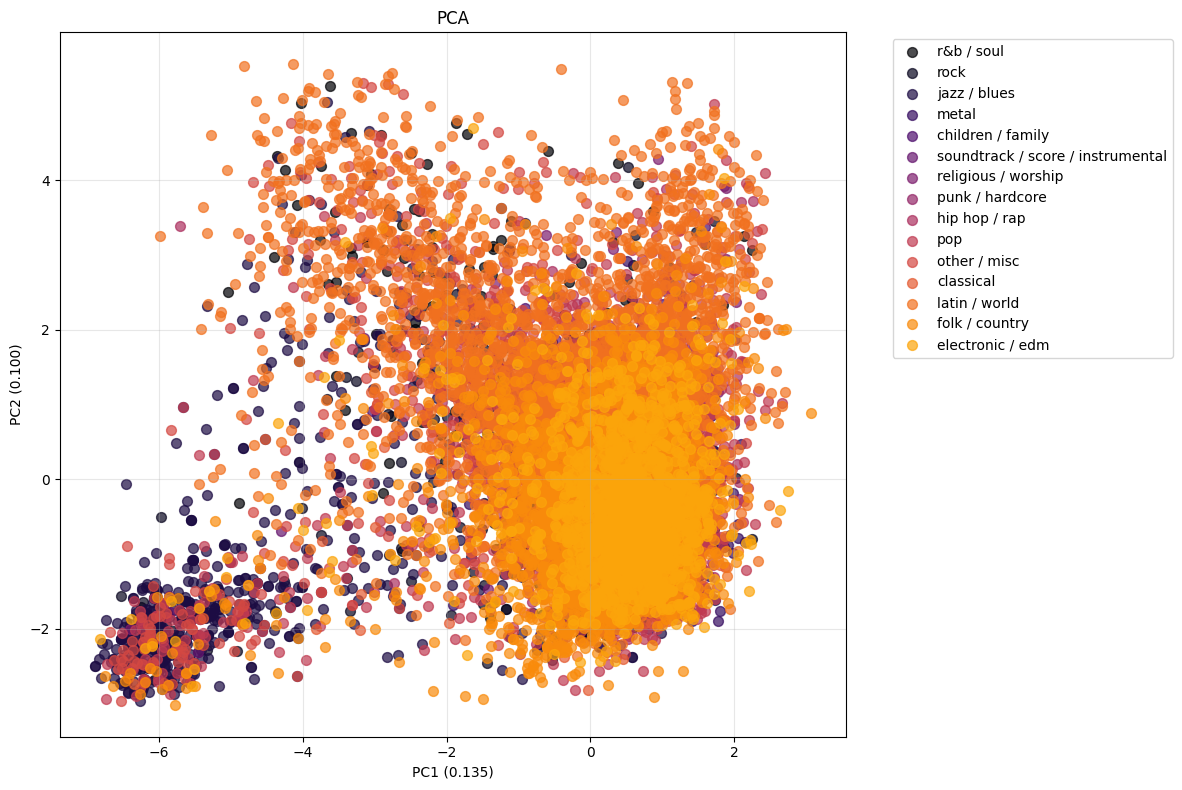

In [19]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def extract_embeddings_for_pca(model, dataloader, device):
   model.eval()
   all_embeddings = []
   all_labels = []
   with torch.no_grad():
       for batch in tqdm(dataloader, desc="Извлечение эмбеддингов"):
           input_ids = batch['input_ids'].to(device)
           attention_mask = batch['attention_mask'].to(device)
           labels = batch['labels'].to(device)
           bert_outputs = model.bert(input_ids=input_ids, attention_mask=attention_mask)
           sequence_output = bert_outputs.last_hidden_state
           lstm_out, _ = model.lstm(sequence_output)
           att_weights = F.softmax(model.attention(lstm_out), dim=1)
           embeddings = torch.sum(att_weights * lstm_out, dim=1)
           all_embeddings.append(embeddings.cpu().numpy())
           all_labels.append(labels.cpu().numpy())
   return np.vstack(all_embeddings), np.vstack(all_labels)

def get_main_genre(labels, genre_to_idx):
    idx_to_genre = {v: k for k, v in genre_to_idx.items()}
    main_genres = []
    for label_vec in labels:
        main_idx = np.argmax(label_vec)
        main_genres.append(idx_to_genre[main_idx])

    return main_genres

model.eval()


# Извлекаем эмбеддинги
embeddings, labels = extract_embeddings_for_pca(model, val_loader, device)
main_genres = get_main_genre(labels, genre_to_idx)

print(f"Размерность эмбеддингов: {embeddings.shape}")
# Применение PCA
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

pca_df = pd.DataFrame({
    'PC1': embeddings_2d[:, 0],
    'PC2': embeddings_2d[:, 1],
    'Genre': main_genres
})

# Визуализация PCA
plt.figure(figsize=(12, 8))
unique_genres = list(set(main_genres))
colors = plt.cm.inferno(np.linspace(0, 0.8, len(unique_genres)))

for i, genre in enumerate(unique_genres):
    genre_data = pca_df[pca_df['Genre'] == genre]
    plt.scatter(genre_data['PC1'], genre_data['PC2'],
               label=genre, alpha=0.7, s=50, color=colors[i])

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.3f})')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.3f})')
plt.title('PCA')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()